Loading and preprocessing CIFAR-10 dataset
Splitting the training data into train and validation sets
Defining the PSO search space for hyperparameters
Defining the fitness function with fixed data arguments
Best hyperparameters found by PSO: num_filters1=70, num_filters2=43, dense_units=688, learning_rate=0.00998842474077105
Training the model with the best hyperparameters
Epoch 1/50
704/704 [==============================] - 153s 215ms/step - loss: 1.7247 - accuracy: 0.4373 - val_loss: 1.2231 - val_accuracy: 0.5600
Epoch 2/50
704/704 [==============================] - 150s 214ms/step - loss: 1.1071 - accuracy: 0.6064 - val_loss: 1.2323 - val_accuracy: 0.5940
Epoch 3/50
704/704 [==============================] - 151s 214ms/step - loss: 0.9660 - accuracy: 0.6583 - val_loss: 1.0267 - val_accuracy: 0.6516
Epoch 4/50
704/704 [==============================] - 151s 215ms/step - loss: 0.8909 - accuracy: 0.6885 - val_loss: 2.0042 - val_accuracy: 0.5688
Epoch 5/50
704/704 [===================

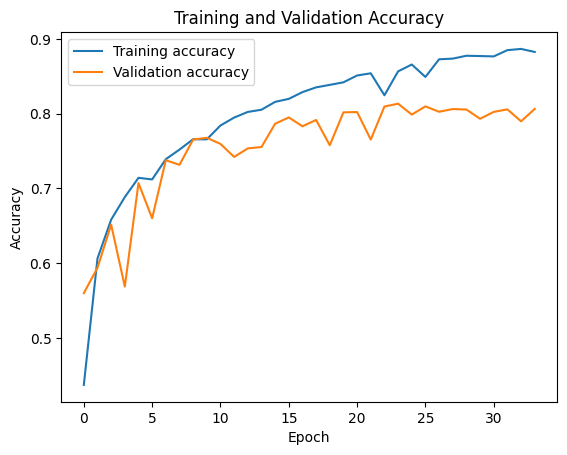

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pyswarms as ps
from functools import partial
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Load and preprocess the CIFAR-10 dataset
print("Loading and preprocessing CIFAR-10 dataset")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = tf.keras.utils.to_categorical(y_train), tf.keras.utils.to_categorical(y_test)

# Split the training data into train and validation sets
print("Splitting the training data into train and validation sets")
validation_split = 0.1
split_index = int(len(x_train) * validation_split)
x_val, y_val = x_train[:split_index], y_train[:split_index]
x_train, y_train = x_train[split_index:], y_train[split_index:]

sample_size = 5000  # Adjust this value as needed
sample_indices = np.random.choice(np.arange(x_train.shape[0]), sample_size, replace=False)

x_train_small = x_train[sample_indices]
y_train_small = y_train[sample_indices]

# Define a fitness function to be optimized using PSO
def fitness_function(hparams, x_train, y_train, x_val, y_val):
    fitness_values = []
    for hparam in hparams:
        num_filters1, num_filters2, dense_units, learning_rate = hparam
        num_filters1 = int(num_filters1)
        num_filters2 = int(num_filters2)
        dense_units = int(dense_units)
        
        print(f"Hyperparameters: num_filters1={num_filters1}, "
              f"num_filters2={num_filters2}, dense_units={dense_units}, "
              f"learning_rate={learning_rate}")

        model = Sequential([
            Conv2D(num_filters1, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
            BatchNormalization(),
            Conv2D(num_filters1, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            Conv2D(num_filters2, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(num_filters2, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            Flatten(),
            Dense(dense_units, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(10, activation='softmax')
        ])

        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(x_train, y_train, epochs=5, batch_size=256,
                            validation_data=(x_val, y_val),
                            callbacks=[early_stopping],
                            verbose=0)

        best_val_acc = max(history.history['val_accuracy'])
        fitness_values.append(1 - best_val_acc)  # Minimize the fitness function (1 - val_accuracy)

    return np.array(fitness_values)

# Define the PSO search space for hyperparameters
print("Defining the PSO search space for hyperparameters")
search_space_bounds = (np.array([16, 16, 128, 1e-5]),
                       np.array([128, 128, 1024, 1e-2]))

# Define the fitness function with fixed data arguments
print("Defining the fitness function with fixed data arguments")
fitness_function_data = partial(fitness_function,
                                x_train=x_train_small, y_train=y_train_small,
                                x_val=x_val, y_val=y_val)

# # Initialize the PSO optimizer
# print("Initializing the PSO optimizer")
# options = {'c1': 1.5, 'c2': 1.5, 'w': 0.9}
# optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=4, options=options,
#                                     bounds=search_space_bounds)

# # Run the PSO optimizer
# print("Running the PSO optimizer")
# cost, best_hyperparams = optimizer.optimize(fitness_function_data, iters=20)

# # Extract the best hyperparameters
# best_num_filters1, best_num_filters2, best_dense_units, best_learning_rate = best_hyperparams
# best_num_filters1 = int(best_num_filters1)
# best_num_filters2 = int(best_num_filters2)
# best_dense_units = int(best_dense_units)

best_num_filters1=70
best_num_filters2=43
best_dense_units=688
best_learning_rate=0.00998842474077105

print(f"Best hyperparameters found by PSO: num_filters1={best_num_filters1}, "
      f"num_filters2={best_num_filters2}, dense_units={best_dense_units}, "
      f"learning_rate={best_learning_rate}")

# Train the model with the best hyperparameters
print("Training the model with the best hyperparameters")
model = Sequential([
    Conv2D(best_num_filters1, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(best_num_filters1, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(best_num_filters2, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(best_num_filters2, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(best_dense_units, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=best_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
start_time = time.time()

history = model.fit(x_train, y_train, epochs=50, batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)
end_time = time.time()

training_time = end_time - start_time
print(f'Total training time: {training_time:.2f} seconds')

# Evaluate the model on the test dataset
print("Evaluating the model on the test dataset")
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print(f'Test accuracy: {test_acc}')

print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes))

print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

# Calculate ROC-AUC for multi-class classification
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print(f'ROC-AUC Score: {roc_auc}')

# Plot the training and validation accuracies
print("Plotting the training and validation accuracies")
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

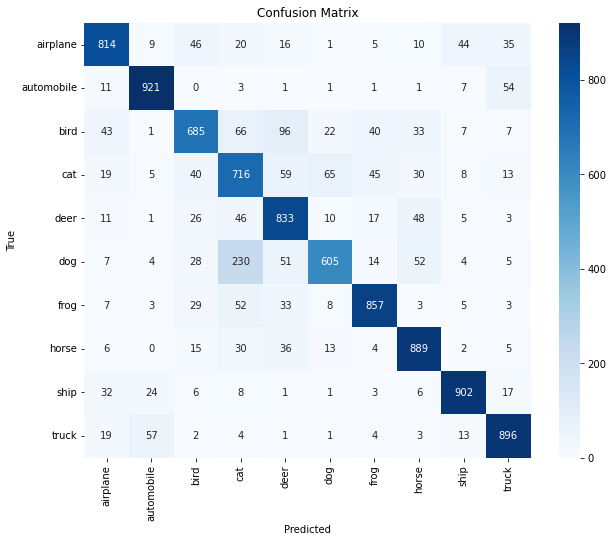

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix data
confusion_matrix = np.array([
    [814, 9, 46, 20, 16, 1, 5, 10, 44, 35],
    [11, 921, 0, 3, 1, 1, 1, 1, 7, 54],
    [43, 1, 685, 66, 96, 22, 40, 33, 7, 7],
    [19, 5, 40, 716, 59, 65, 45, 30, 8, 13],
    [11, 1, 26, 46, 833, 10, 17, 48, 5, 3],
    [7, 4, 28, 230, 51, 605, 14, 52, 4, 5],
    [7, 3, 29, 52, 33, 8, 857, 3, 5, 3],
    [6, 0, 15, 30, 36, 13, 4, 889, 2, 5],
    [32, 24, 6, 8, 1, 1, 3, 6, 902, 17],
    [19, 57, 2, 4, 1, 1, 4, 3, 13, 896]
])

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()